In [1]:
%matplotlib inline
from segpy.reader import create_reader
from segpy.writer import write_segy

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image

import os
import shutil

from collections import defaultdict, Counter
import joblib
import pickle

from scipy.stats import mode
from scipy.stats import entropy
from scipy import ndimage

%run bp_smc_example.ipynb

In [2]:
os.chdir('C:/Users/jsbae/geo-owl-ogy/Josh\'s Workspace')

In [3]:
print(len(os.listdir('small_dataset')))
# print(len(os.listdir('large_dataset')))

119


In [4]:
# split up stack and gather files into separate directories
for filename in os.listdir('large_dataset'):
    src = 'large_dataset/' + filename
    if 'gather' in filename:
        dst = 'large_gather/' + filename
        shutil.copy(src, dst)

In [3]:
# make a dictionary of arrays for every realization in stack
large_gather_dict = {}
for filename in os.listdir('large_gather')[1:-1]:
    arr = np.zeros((1058, 39, 400))
    with open(f'large_gather/{filename}', 'rb') as segy_in_file:
        segy_reader = create_reader(segy_in_file, endian='>')
        count = 0
        for trace_index in segy_reader.trace_indexes():
            data = segy_reader.trace_samples(trace_index)
            for i in range(len(data)):
                arr[int(trace_index / 39), trace_index % 39, i] = data[i]
    large_gather_dict[filename] = arr
    

KeyboardInterrupt: 

In [8]:
# split up stack and gather files into separate directories
for filename in os.listdir('small_dataset'):
    src = 'small_dataset/' + filename
    if 'gather' in filename:
        dst = 'gather/' + filename
        shutil.copy(src, dst)
    if 'stack' in filename:
        dst = 'stack/' + filename
        shutil.copy(src, dst)
        
# # make a dictionary of arrays for every realization in stack
# stack_dict = {}
# for filename in os.listdir('stack')[1:-1]:
#     arr = np.zeros((1058, 400))

#     with open(f'stack/{filename}', 'rb') as segy_in_file:
#         segy_reader = create_reader(segy_in_file, endian='>')

#         for trace_index in segy_reader.trace_indexes():
#             data = segy_reader.trace_samples(trace_index)
#             for i in range(len(data)):
#                 arr[trace_index, i] = data[i]
#     stack_dict[filename] = arr
    
# # make a dictionary of arrays for every realization in stack
# gather_dict = {}
# for filename in os.listdir('gather')[1:-1]:
#     arr = np.zeros((1058, 39, 400))
#     with open(f'gather/{filename}', 'rb') as segy_in_file:
#         segy_reader = create_reader(segy_in_file, endian='>')

#         count = 0
#         for trace_index in segy_reader.trace_indexes():
#             data = segy_reader.trace_samples(trace_index)
#             for i in range(len(data)):
#                 arr[int(trace_index / 39), trace_index % 39, i] = data[i]
#     gather_dict[filename] = arr
    

In [9]:
print_segy_info('stack/img_12.stack.segy')

Filename:              stack/img_12.stack.segy
SEG Y revision:        SegYRevision.REVISION_0
Number of traces:      1058
Data format:           IBM 32 bit float
Dimensionality:        0

=== BEGIN TEXTUAL REEL HEADER ===
C01  BP syntheitc Date: 05/20/2019                                              
C02  image stack scenario with the following dimension                          
C03  axis  :         z         x         y                                      
C04  size  :       400      1058         1                                      
C05  origin:   0.00000   0.00000   0.00000                                      
C06  delta :  10.00000  10.00000  10.00000                                      
=== END TEXTUAL REEL HEADER ===


In [4]:
# load the two dictionaries into the directory to use later
# joblib.dump(stack_dict, 'stack_dict')
stack_dict = joblib.load(open('stack_dict', 'rb'))

# joblib.dump(gather_dict, 'gather_dict')
gather_dict = joblib.load(open('gather_dict', 'rb'))

# joblib.dump(large_gather_dict, 'large_gather_dict')
# large_gather_dict = joblib.load(open('large_gather_dict', 'rb'))

In [13]:
# functions for getting the mode and kl_divergence
def mode_func(x):
    values, counts = np.unique(x, return_counts=True)
    m = counts.argmax()
    return values[m], 

# this function is not necessary
def kl_divergence(p, q):
    kl1 = np.sum(np.where(p != 0, p * np.log(p / q), 0))
    kl2 = np.sum(np.where(q != 0, q * np.log(q / p), 0))
    return (kl1 + kl2) / 2

In [16]:
good_realizations = joblib.load(open('good_realizations', 'rb'))
good_realizations

['img_13.gather.segy',
 'img_15.gather.segy',
 'img_16.gather.segy',
 'img_17.gather.segy',
 'img_18.gather.segy',
 'img_19.gather.segy',
 'img_2.gather.segy',
 'img_20.gather.segy',
 'img_21.gather.segy',
 'img_24.gather.segy',
 'img_25.gather.segy',
 'img_26.gather.segy',
 'img_29.gather.segy',
 'img_32.gather.segy',
 'img_33.gather.segy',
 'img_34.gather.segy',
 'img_36.gather.segy',
 'img_38.gather.segy',
 'img_41.gather.segy',
 'img_42.gather.segy',
 'img_44.gather.segy',
 'img_46.gather.segy',
 'img_5.gather.segy',
 'img_52.gather.segy',
 'img_56.gather.segy',
 'img_58.gather.segy',
 'img_59.gather.segy',
 'img_6.gather.segy',
 'img_7.gather.segy']

In [18]:
# make a new stack_dict based on the quality of their gathers
good_real_files = []
for file in good_realizations:
    good_real_files.append(file.replace('gather', 'stack'))

good_stack_dict = dict((key, stack_dict[key]) for key in good_real_files)
print(len(good_stack_dict))

29


In [14]:
# joblib.dump(good_stack_dict, 'good_stack_dict')
good_stack_dict = joblib.load(open('good_stack_dict', 'rb'))

In [12]:
# function computes the uncertainty image of all the stack segy files
cnt = Counter()

def uncertainty_image(stack_dict):
    # kl_arr is the array that will compute uncertainty image of all realizations  
    kl_arr = np.zeros((1058, 400))
    
    # big_arr makes a 3-d numpy array that will store pixels of each realization
    big_arr = np.zeros((len(stack_dict), 1058, 400))
    
    index = 0
    for key in stack_dict.keys():
        arr = stack_dict[key]
        big_arr[index, :, :] = arr
        index += 1  
    
    # give every pixel value a kl_divergence value based on distributions
    
    big_arr_min = big_arr.min()
    big_arr_max = big_arr.max()
    for i in range(1058):
        for j in range(400):

            # create bins corresponding to the range of each length 58 arr
            arr = big_arr[:, i, j]
            bins = np.linspace(big_arr_min, big_arr_max, num=11)
            binned_arr = np.digitize(arr, bins, right=True)

            # count up the frequency of the bins that occupied and find the most frequently occurring value
            cnt = np.zeros(10)
            for val in binned_arr:
                cnt[val-1] += 1

            freq_arr = cnt
            max_val = max(freq_arr)

            # one hot encode a length 10 vector to give a 1 to the bin with the most number of values in it
            onehot_arr = [1e-9 if x != max_val else 1.0 - (1e-9 * (len(freq_arr) - 1)) for x in freq_arr]

            # compute kl between one hot vector and freq_arr which is a likelihood probability vector of the bins
            kl_score = entropy(freq_arr, onehot_arr)

            # store the kl_score as a matrix filled with that value
            kl_arr[i, j] = kl_score

    score_arr = kl_arr

    score_arr = score_arr.transpose()
    min_arr = score_arr.min()
    max_arr = score_arr.max()
    score_arr = (score_arr - min_arr) / (max_arr - min_arr)
    score_arr = score_arr * 255

    im = Image.fromarray(score_arr)
    im = im.convert('RGB')

    return score_arr, im

In [15]:
# small_kl_arr, small_image = uncertainty_image(stack_dict)
good_kl_arr, good_image = uncertainty_image(good_stack_dict)

# large_kl_arr, large_image = uncertainty_image(large_dict)

In [16]:
# save images
# joblib.dump(small_image, 'small_image')
small_image = joblib.load(open('small_image', 'rb'))
# joblib.dump(good_image, 'good_image')
good_image = joblib.load(open('good_image', 'rb'))

joblib.dump(small_kl_arr, 'small_kl_arr')
small_kl_arr = joblib.load(open('small_kl_arr', 'rb'))
joblib.dump(good_kl_arr, 'good_kl_arr')
good_kl_arr = joblib.load(open('good_kl_arr', 'rb'))

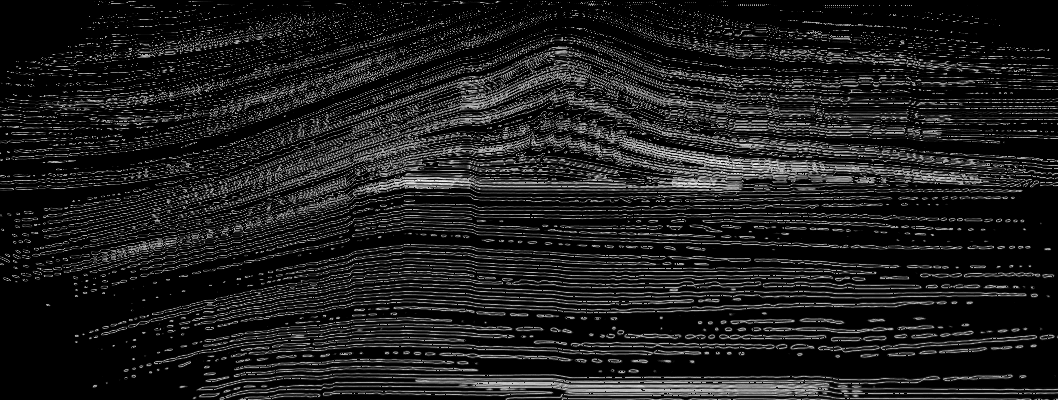

In [7]:
small_image

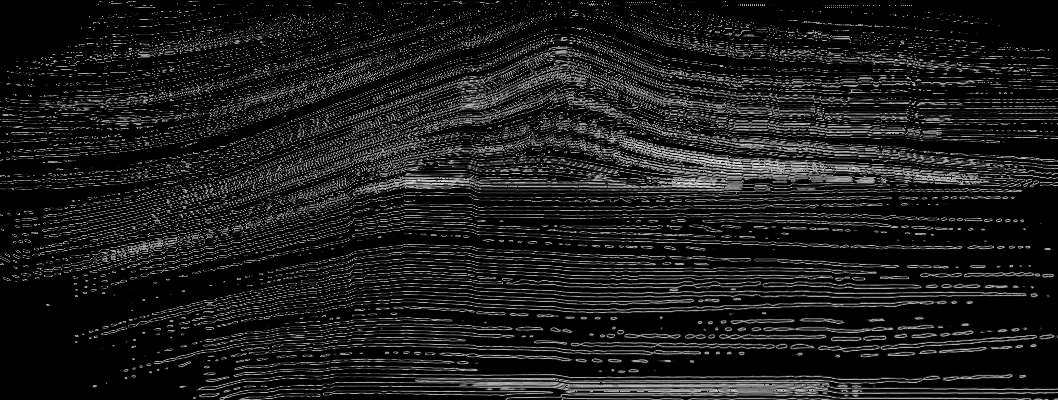

In [8]:
good_image

In [17]:
diff_arr = small_kl_arr - good_kl_arr

im = Image.fromarray(diff_arr)
diff_im = im.convert('RGB')

# joblib.dump(diff_im, 'diff_im')
diff_im = joblib.load(open('diff_im', 'rb'))

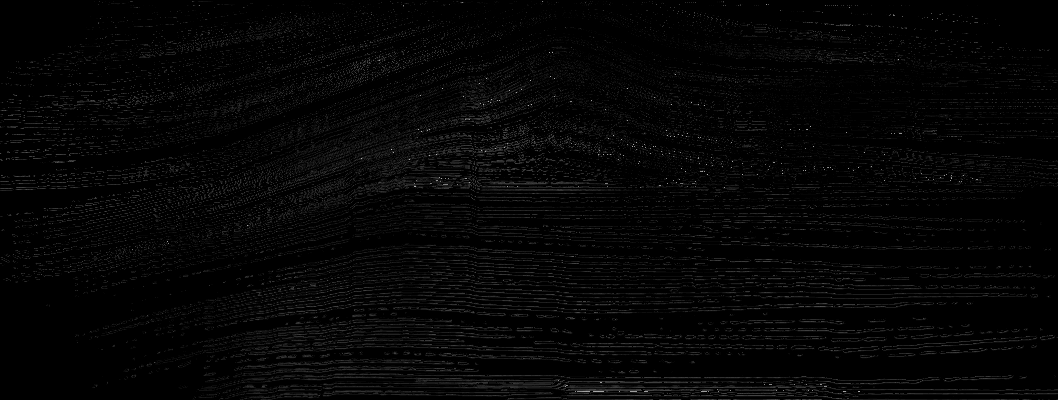

In [18]:
diff_im

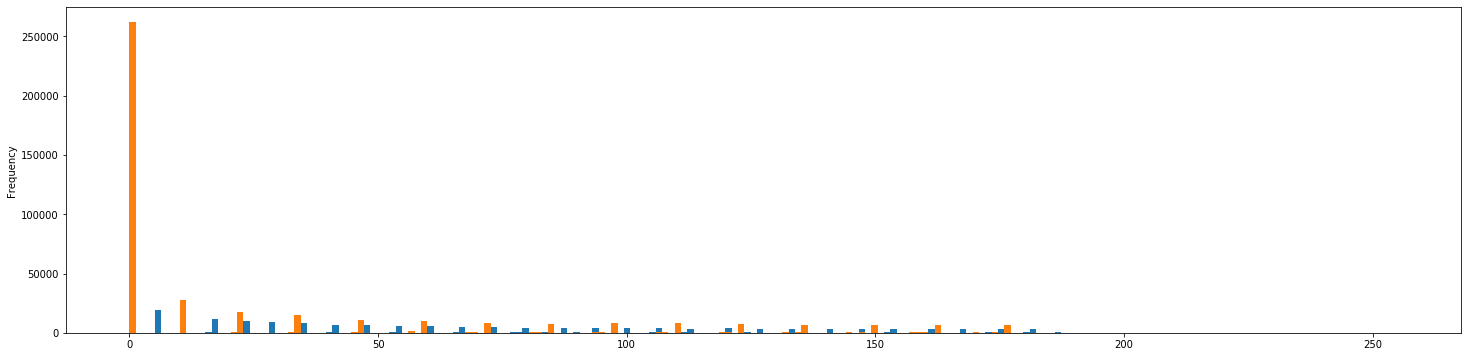

In [19]:
# visualizes 
pd.Series(small_kl_arr.flatten()).plot(kind='hist', figsize=(25, 6), bins=200);
pd.Series(good_kl_arr.flatten()).plot(kind='hist', figsize=(25, 6), bins=200);

In [92]:
def crop_and_zoom(im, lo, hi, basewidth):
    cropped = im.crop((lo[0], lo[1], hi[0], hi[1]))
    wpercent = (basewidth/float(cropped.size[0]))
    hsize = int((float(cropped.size[1])*float(wpercent)))
    return cropped.resize((basewidth,hsize), Image.ANTIALIAS).convert('RGB')

def crop_zoom_concat(arr1, arr2, lo, hi, basewidth):
    cropped1 = arr1[lo[1]:hi[1], lo[0]:hi[0]]
    cropped2 = arr2[lo[1]:hi[1], lo[0]:hi[0]]
    # rescale the two cropped images
    min1 = cropped1.min()
    max1 = cropped1.max()
    cropped1 = (cropped1 - min1) / (max1 - min1)
    cropped1 = cropped1 * 255
    min2 = cropped2.min()
    max2 = cropped2.max()
    cropped2 = (cropped2 - min2) / (max2 - min2)
    cropped2 = cropped2 * 255
    stacked = np.hstack((cropped1, cropped2))
    print(stacked.shape)
    img = Image.fromarray(stacked)
    wpercent = (basewidth/float(img.size[0]))
    hsize = int((float(img.size[1])*float(wpercent)))
    return img.resize((basewidth,hsize), Image.ANTIALIAS).convert('RGB')

In [2]:
# crop_and_zoom(image, (400, 200), (450, 220), 1000)
# crop_zoom_concat(kl_arr.transpose(), stack_dict['img_2.stack.segy'].transpose(), (400, 200), (450, 220), 1500)
# crop_zoom_concat(kl_arr.transpose(), stack_dict['img_4.stack.segy'].transpose(), (500, 370), (550, 390), 1500)

NameError: name 'crop_and_zoom' is not defined

<h2 style="color:blue;"> Process gathers and find standard deviation summations for each realization </h2>

In [20]:
def gather_std(gather_dict, ncols=1058):
    std_dict = defaultdict(list)

    std_sums = defaultdict(list)
    for key in gather_dict.keys():
        arr = gather_dict[key]
        std_sum = 0
        
        # for each of the 1058 ncol GATHERs
        for c in range(ncols):
            # Pull out all offset pairs for a given x
            sub_arr = arr[c, :, :]
            sub_arr = sub_arr.transpose()
            min_arr = sub_arr.min()
            max_arr = sub_arr.max()
            sub_arr = (sub_arr - min_arr) / (max_arr - min_arr)
            sub_arr = sub_arr * 255
            
            std_val = np.std(sub_arr, axis=0).sum()
            std_dict[key].append(std_val)
        
    return std_dict

std_dict = gather_std(gather_dict)

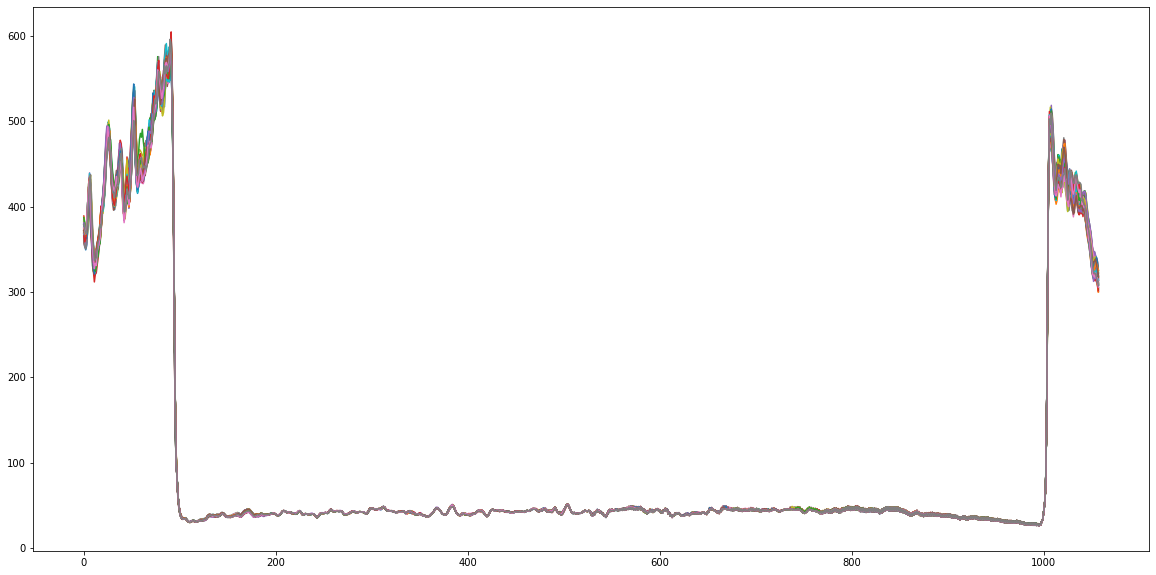

In [21]:
# this plots the std deviation distribution of the rows of all 1058 gathers
plt.figure(figsize=(20, 10))
for key in std_dict:
    plt.plot(std_dict[key])

In [22]:
joblib.dump(std_dict, 'std_dict')
std_dict = joblib.load(open('std_dict', 'rb'))

In [23]:
min_std = std_dict['img_1.gather.segy'].index(min(std_dict['img_1.gather.segy']))
max_std = std_dict['img_1.gather.segy'].index(max(std_dict['img_1.gather.segy']))
std_list = [min_std, max_std]

# sort by lowest to highest std among gathers for one image
sort_std = sorted(std_dict['img_1.gather.segy'])
min5_std = sort_std[0:10]
max5_std = sort_std[-11:-1]

# get their indices
min_std_ind = [std_dict['img_1.gather.segy'].index(x) for x in min5_std]
max_std_ind = [std_dict['img_1.gather.segy'].index(x) for x in max5_std]

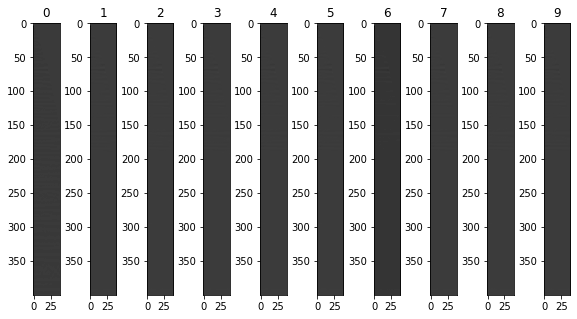

In [24]:
# top 10 gathers with lowest total std (image 1)
nrows = 1
ncols = 10
f, axarr = matplotlib.pyplot.subplots(nrows, ncols, figsize = (10, 5))

c = 0
for index in min_std_ind:
    # Pull out all offset pairs for a given x
    sub_arr = gather_dict['img_1.gather.segy'][index, :, :]
    sub_arr = sub_arr.transpose()
    min_arr = sub_arr.min()
    max_arr = sub_arr.max()
    sub_arr = (sub_arr - min_arr) / (max_arr - min_arr)
    sub_arr = sub_arr * 255
    
    axarr[c].imshow(sub_arr, cmap = 'gray')
    
    title = str(c)
    axarr[c].set_title(title.strip())
    c += 1

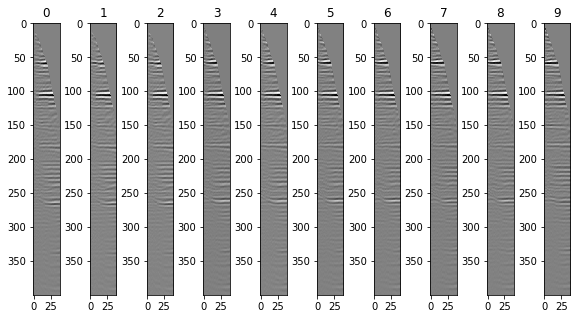

In [25]:
# top 10 gathers with highest total std (image 1)
nrows = 1
ncols = 10
f, axarr = matplotlib.pyplot.subplots(nrows, ncols, figsize = (10, 5))

c = 0
for index in max_std_ind:
    # Pull out all offset pairs for a given x
    sub_arr = gather_dict['img_1.gather.segy'][index, :, :]
    sub_arr = sub_arr.transpose()
    min_arr = sub_arr.min()
    max_arr = sub_arr.max()
    sub_arr = (sub_arr - min_arr) / (max_arr - min_arr)
    sub_arr = sub_arr * 255
    
    axarr[c].imshow(sub_arr, cmap = 'gray')
    
    title = str(c)
    axarr[c].set_title(title.strip())
    c += 1

<h2 style="color:blue;"> Process gathers using canny filter and determine the quality determined by horizontal lines </h2>

In [ ]:
print(gather_dict['img_1.gather.segy'].shape)

In [28]:
# collect all (transposed) sub arrays of 1058 gathers from image_10_gather.segy
    
def get_subarrs(gather_dict):
    nrows = 1
    ncols = 1058

    gather_sub_arrs = defaultdict(list)
    sub_arrs = []

    for key in gather_dict:
        print(key)
        sub_arrs = []
        for c in range(ncols):
            
            # Pull out all offset pairs for a given x
            sub_arr = gather_dict[key][c, :, :]
            sub_arr = sub_arr.transpose()
            sub_arrs.append(sub_arr)
        gather_sub_arrs[key] = sub_arrs
    return gather_sub_arrs

gather_sub_arrs = get_subarrs(gather_dict)

img_1.gather.segy
img_10.gather.segy
img_11.gather.segy
img_12.gather.segy
img_13.gather.segy
img_14.gather.segy
img_15.gather.segy
img_16.gather.segy
img_17.gather.segy
img_18.gather.segy
img_19.gather.segy
img_2.gather.segy
img_20.gather.segy
img_21.gather.segy
img_22.gather.segy
img_23.gather.segy
img_24.gather.segy
img_25.gather.segy
img_26.gather.segy
img_27.gather.segy
img_28.gather.segy
img_29.gather.segy
img_3.gather.segy
img_30.gather.segy
img_31.gather.segy
img_32.gather.segy
img_33.gather.segy
img_34.gather.segy
img_35.gather.segy
img_36.gather.segy
img_37.gather.segy
img_38.gather.segy
img_39.gather.segy
img_4.gather.segy
img_40.gather.segy
img_41.gather.segy
img_42.gather.segy
img_43.gather.segy
img_44.gather.segy
img_45.gather.segy
img_46.gather.segy
img_47.gather.segy
img_48.gather.segy
img_49.gather.segy
img_5.gather.segy
img_50.gather.segy
img_51.gather.segy
img_52.gather.segy
img_53.gather.segy
img_54.gather.segy
img_55.gather.segy
img_56.gather.segy
img_57.gather.seg

In [29]:
len(gather_sub_arrs['img_1.gather.segy'][0][0])

39

In [ ]:
# to demonstrate how the rows are being eliminated from the gathers

plt.figure(figsize=(20, 10))
# most values are centered around 0 and any value outside of -5 and 5 were eliminated 
for sub_arr in clean_sub_arrs:
    plt.hist(clean_sub_arrs[sub_arr].flatten(), bins=20, log=True);

In [30]:
# eliminate any rows of gathers that have values greater than 5 or less than -5

def clean_gathers(gather_sub_arrs):
    max_val = 5
    min_val = -5
    clean_dict = defaultdict(list)
    for key in gather_sub_arrs:
        print(key)
        sub_arrs = gather_sub_arrs[key]
        new_sub_arrs = []

        c = 0
        for sub_arr in sub_arrs:
            truth_lst = []
            for arr in sub_arr:
                truth_lst.append(np.any(arr > 5) or np.any(arr < -5))
        #     print('number of Falses', truth_lst.count(False))
            idx = np.where(np.array(truth_lst) == False)
            new_sub_arrs.append(sub_arr[idx])
            c += 1
        clean_dict[key] = new_sub_arrs
    return clean_dict

clean_sub_arrs = clean_gathers(gather_sub_arrs)

img_1.gather.segy
img_10.gather.segy
img_11.gather.segy
img_12.gather.segy
img_13.gather.segy
img_14.gather.segy
img_15.gather.segy
img_16.gather.segy
img_17.gather.segy
img_18.gather.segy
img_19.gather.segy
img_2.gather.segy
img_20.gather.segy
img_21.gather.segy
img_22.gather.segy
img_23.gather.segy
img_24.gather.segy
img_25.gather.segy
img_26.gather.segy
img_27.gather.segy
img_28.gather.segy
img_29.gather.segy
img_3.gather.segy
img_30.gather.segy
img_31.gather.segy
img_32.gather.segy
img_33.gather.segy
img_34.gather.segy
img_35.gather.segy
img_36.gather.segy
img_37.gather.segy
img_38.gather.segy
img_39.gather.segy
img_4.gather.segy
img_40.gather.segy
img_41.gather.segy
img_42.gather.segy
img_43.gather.segy
img_44.gather.segy
img_45.gather.segy
img_46.gather.segy
img_47.gather.segy
img_48.gather.segy
img_49.gather.segy
img_5.gather.segy
img_50.gather.segy
img_51.gather.segy
img_52.gather.segy
img_53.gather.segy
img_54.gather.segy
img_55.gather.segy
img_56.gather.segy
img_57.gather.seg

In [31]:
len(clean_sub_arrs['img_1.gather.segy'][0][0])

39

In [32]:
# joblib.dump(clean_sub_arrs, 'clean_sub_arrs')
clean_sub_arrs = joblib.load(open('clean_sub_arrs', 'rb'))

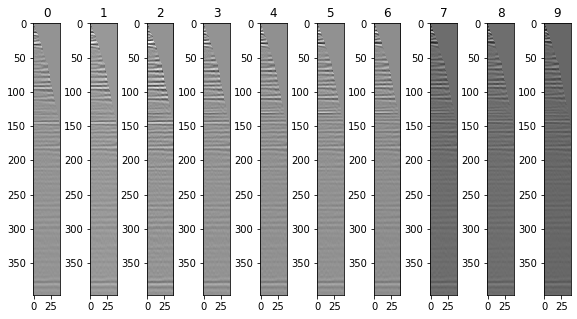

In [38]:
# plot new gathers after eliminating outlier rows (they are much easier to see without outlier pixels)
nrows = 1
ncols = 10

f, axarr = matplotlib.pyplot.subplots(nrows, ncols, figsize = (10, 5))

for c in range(500, 510):
    sub_arr = clean_sub_arrs['img_1.gather.segy'][c]
    sub_shape = sub_arr.shape
    min_arr = sub_arr.min()
    max_arr = sub_arr.max()
    sub_arr = (sub_arr - min_arr) / (max_arr - min_arr)

    sub_arr = sub_arr * 255
    
    axarr[c-500].imshow(sub_arr, cmap = 'gray')

    title = str(c-500)
    axarr[c-500].set_title(title.strip())

img_1.gather.segy
img_10.gather.segy
img_11.gather.segy
img_12.gather.segy
img_13.gather.segy
img_14.gather.segy
img_15.gather.segy
img_16.gather.segy
img_17.gather.segy
img_18.gather.segy
img_19.gather.segy
img_2.gather.segy
img_20.gather.segy
img_21.gather.segy
img_22.gather.segy
img_23.gather.segy
img_24.gather.segy
img_25.gather.segy
img_26.gather.segy
img_27.gather.segy
img_28.gather.segy
img_29.gather.segy
img_3.gather.segy
img_30.gather.segy
img_31.gather.segy
img_32.gather.segy
img_33.gather.segy
img_34.gather.segy
img_35.gather.segy
img_36.gather.segy
img_37.gather.segy
img_38.gather.segy
img_39.gather.segy
img_4.gather.segy
img_40.gather.segy
img_41.gather.segy
img_42.gather.segy
img_43.gather.segy
img_44.gather.segy
img_45.gather.segy
img_46.gather.segy
img_47.gather.segy
img_48.gather.segy
img_49.gather.segy
img_5.gather.segy
img_50.gather.segy
img_51.gather.segy
img_52.gather.segy
img_53.gather.segy
img_54.gather.segy
img_55.gather.segy
img_56.gather.segy
img_57.gather.seg

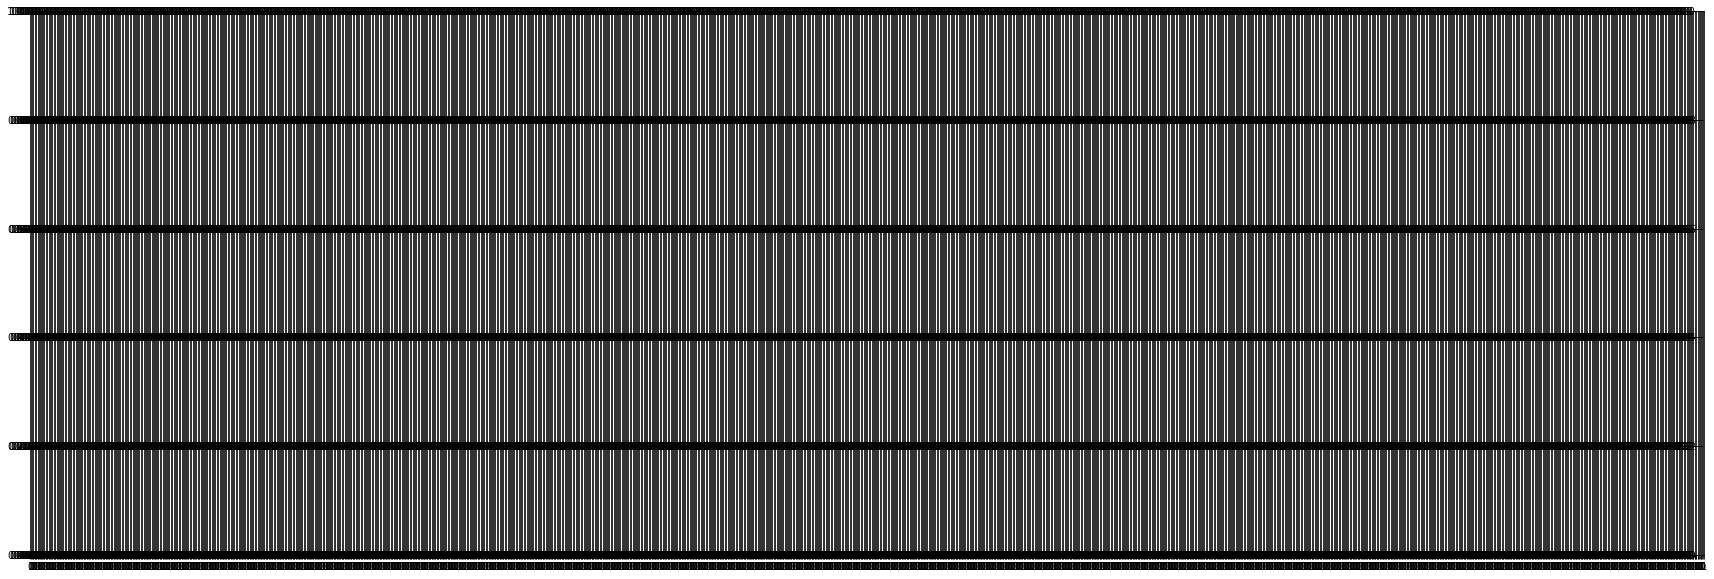

In [17]:
# apply canny filter to all the cleaned sub arrays to pick out optimal sigma
from skimage import feature

def get_canny_gather(gather_dict):
    ncols = 1058

    canny_dict = {}

    for key in gather_dict:
        print(key)
        edge_list = []
        for c in range(ncols):
            # Pull out all offset pairs for a given x
            sub_arr = clean_sub_arrs[key][c]
            sub_shape = sub_arr.shape
            min_arr = sub_arr.min()
            max_arr = sub_arr.max()
            sub_arr = (sub_arr - min_arr) / (max_arr - min_arr)
            sub_arr = sub_arr * 255

            edges = feature.canny(sub_arr, sigma=4)
            edge_list.append(edges)
        canny_dict[key] = edge_list
    return canny_dict

canny_dict = get_canny_gather(gather_dict)

In [39]:
# joblib.dump(canny_dict, 'canny_dict')
canny_dict = joblib.load(open('canny_dict', 'rb'))

In [40]:
len(canny_dict['img_1.gather.segy'][0][0])

39

In [6]:
# length 1058 dictionaries, capturing information on all gathers' mode, mean, difference information among their rows
def canny_func(canny_dict):
    for key in canny_dict:
        print(key)
#         mode_dict = defaultdict(list)
#         mean_dict = defaultdict(list)
#         diff_dict = defaultdict(int)

        for c in range(1058):
            canny_dict[key][c] = canny_dict[key][c].astype(int)
#             for row in canny_dict[key][c]:
#                 mode_dict[c].append(mode(row)[0][0])
#                 mean_dict[c].append(np.mean(row))
#                 counter_dict = Counter(mode_dict[c])
#                 cnt_0, cnt_1 = counter_dict[0], counter_dict[1]
#                 diff_dict[c] = abs(cnt_0 - cnt_1)

#         canny_num_dict[key] = mode_dict, mean_dict, diff_dict
    return canny_dict

canny_num_dict = canny_func(canny_dict)

img_1.gather.segy
img_10.gather.segy
img_11.gather.segy
img_12.gather.segy
img_13.gather.segy
img_14.gather.segy
img_15.gather.segy
img_16.gather.segy
img_17.gather.segy
img_18.gather.segy
img_19.gather.segy
img_2.gather.segy
img_20.gather.segy
img_21.gather.segy
img_22.gather.segy
img_23.gather.segy
img_24.gather.segy
img_25.gather.segy
img_26.gather.segy
img_27.gather.segy
img_28.gather.segy
img_29.gather.segy
img_3.gather.segy
img_30.gather.segy
img_31.gather.segy
img_32.gather.segy
img_33.gather.segy
img_34.gather.segy
img_35.gather.segy
img_36.gather.segy
img_37.gather.segy
img_38.gather.segy
img_39.gather.segy
img_4.gather.segy
img_40.gather.segy
img_41.gather.segy
img_42.gather.segy
img_43.gather.segy
img_44.gather.segy
img_45.gather.segy
img_46.gather.segy
img_47.gather.segy
img_48.gather.segy
img_49.gather.segy
img_5.gather.segy
img_50.gather.segy
img_51.gather.segy
img_52.gather.segy
img_53.gather.segy
img_54.gather.segy
img_55.gather.segy
img_56.gather.segy
img_57.gather.seg

In [41]:
# joblib.dump(canny_num_dict, 'canny_num_dict')
canny_num_dict = joblib.load(open('canny_num_dict', 'rb'))

In [84]:
# this implements the method of getting the distance between neighboring columns in a gather and summing them together to get an overall score for each gather
# low score: similar columns (better gather), high score: dissimilar columns (worse gather)

def dist_func(canny_num_dict):
    realization_scores = defaultdict(int)
    gather_scores = defaultdict(dict)
    for key in canny_num_dict:
        print(key)
        for c in range(1058):
            gather = np.transpose(canny_num_dict[key][c])
            dist_sum = 0
            for d in range(39):
                if d == 0:
                    score = np.linalg.norm(gather[d] - gather[d + 1])
                    dist_sum += score
                elif d == 38:
                    score = np.linalg.norm(gather[d] - gather[d - 1])
                    dist_sum += score
                else:
                    score = np.linalg.norm(gather[d] - gather[d - 1]) + np.linalg.norm(gather[d] - gather[d + 1])
                    dist_sum += score
            gather_scores[key][c] = dist_sum
        gather_sum = sum(gather_scores[key].values())
        realization_scores[key] = gather_sum
    return realization_scores, gather_scores

realization_scores, gather_scores = dist_func(canny_num_dict)

img_1.gather.segy
img_10.gather.segy
img_11.gather.segy
img_12.gather.segy
img_13.gather.segy
img_14.gather.segy
img_15.gather.segy
img_16.gather.segy
img_17.gather.segy
img_18.gather.segy
img_19.gather.segy
img_2.gather.segy
img_20.gather.segy
img_21.gather.segy
img_22.gather.segy
img_23.gather.segy
img_24.gather.segy
img_25.gather.segy
img_26.gather.segy
img_27.gather.segy
img_28.gather.segy
img_29.gather.segy
img_3.gather.segy
img_30.gather.segy
img_31.gather.segy
img_32.gather.segy
img_33.gather.segy
img_34.gather.segy
img_35.gather.segy
img_36.gather.segy
img_37.gather.segy
img_38.gather.segy
img_39.gather.segy
img_4.gather.segy
img_40.gather.segy
img_41.gather.segy
img_42.gather.segy
img_43.gather.segy
img_44.gather.segy
img_45.gather.segy
img_46.gather.segy
img_47.gather.segy
img_48.gather.segy
img_49.gather.segy
img_5.gather.segy
img_50.gather.segy
img_51.gather.segy
img_52.gather.segy
img_53.gather.segy
img_54.gather.segy
img_55.gather.segy
img_56.gather.segy
img_57.gather.seg

In [79]:
# joblib.dump(realization_scores, 'realization_scores')
realization_scores = joblib.load(open('realization_scores', 'rb'))

# joblib.dump(gather_scores, 'gather_scores')
gather_scores = joblib.load(open('gather_scores', 'rb'))

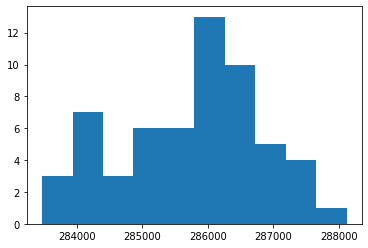

In [43]:
# plot distribution of realization scores
plt.hist(realization_scores.values());

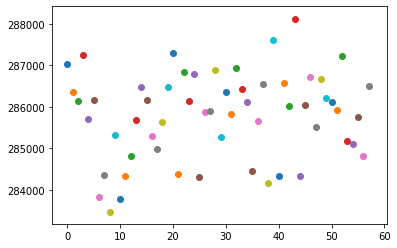

In [44]:
# scatter plot version
for counter, value in enumerate(realization_scores.values()):
    plt.scatter(counter, value)

<h2 style="color:blue;"> Identify best realizations based on gather-distance scores </h2>

In [14]:
# identify realizations that fall under the given score threshold of 286000
good_realizations = []
for key in realization_scores:
    if realization_scores[key] < 286000:
        good_realizations.append(key)

In [45]:
# joblib.dump(good_realizations, 'good_realizations')
good_realizations = joblib.load(open('good_realizations', 'rb'))

# go back up to the top to see what we did with this

In [88]:
# identify the bad and good gathers (for realization 1) based on distance scores
random_real = gather_scores['img_1.gather.segy']

In [89]:
# get the indices of the top ten best and worst realizations
def gather_indices(realization_scores):
    dist_lst = sorted(realization_scores.items(), key=lambda x: x[1])
    low_scores_idx = [x[0] for x in dist_lst[0:10]]
    high_scores_idx = [x[0] for x in dist_lst[-11:-1]]
    return low_scores_idx, high_scores_idx

low_scores_idx, high_scores_idx = gather_indices(random_real)

In [90]:
low_scores_idx, high_scores_idx

([998, 351, 1000, 350, 349, 100, 362, 1002, 130, 99],
 [34, 4, 5, 36, 3, 38, 9, 41, 2, 42])

In [97]:
# get the canny-filtered arrays of these good and bad gathers
canny_lst_low = [canny_num_dict['img_1.gather.segy'][i] for i in low_scores_idx]
canny_lst_high = [canny_num_dict['img_1.gather.segy'][i] for i in high_scores_idx]

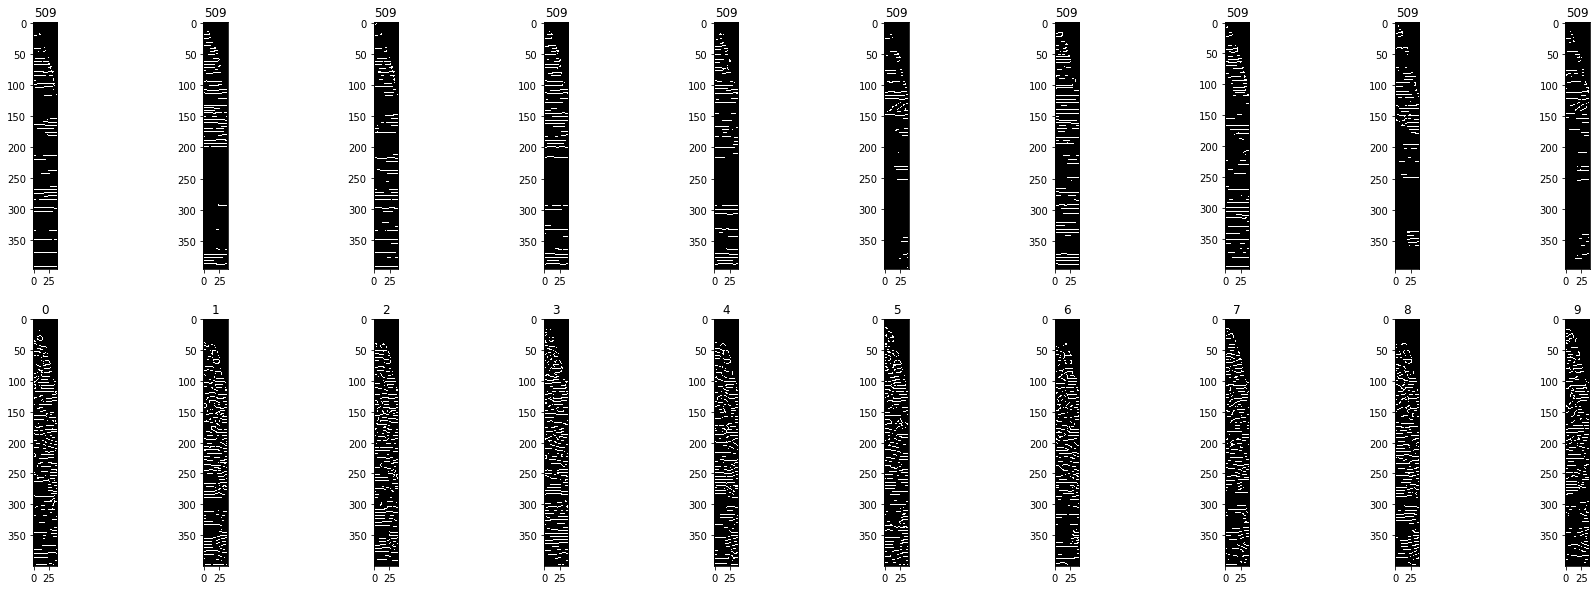

In [99]:
# among the 10 best and 10 worst gathers for image 1, check out their canny images
nrows = 2
ncols = 10

f, axarr = matplotlib.pyplot.subplots(nrows, ncols, figsize = (30, 10))

for i in range(10):
    axarr[0, i].imshow(canny_lst_low[i], cmap = 'gray')
    title = str(c)
    axarr[0, i].set_title(title.strip())

# canny_img = [canny_dict[i] for i in high_scores_idx]
for i in range(10):
    axarr[1, i].imshow(canny_lst_high[i], cmap = 'gray')
    title = str(i)
    axarr[1, i].set_title(title.strip())

In [102]:
# get the arrays of the cleaned arrays of the original gathers
canny_arr_low = [clean_sub_arrs['img_1.gather.segy'][i] for i in low_scores_idx]
canny_arr_high = [clean_sub_arrs['img_1.gather.segy'][i] for i in high_scores_idx]

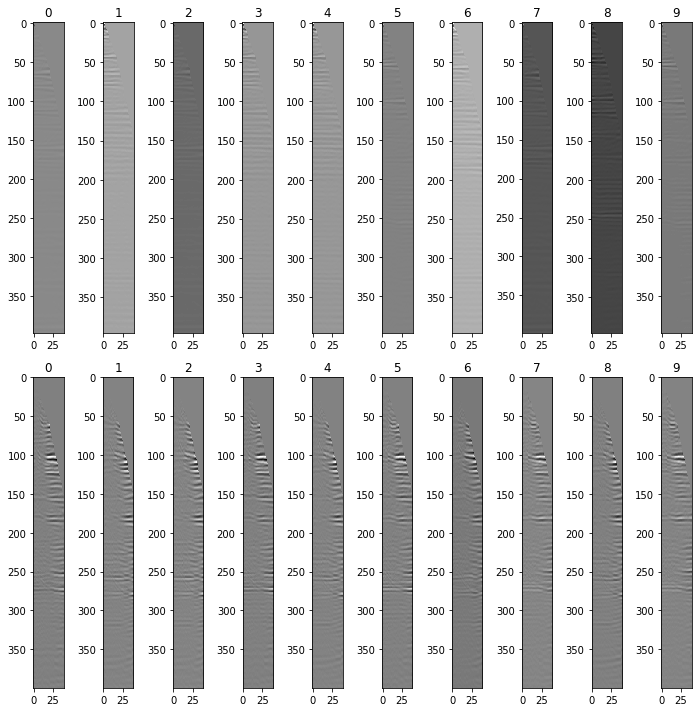

In [106]:
# plot original gather images of the top 10 worst and best gathers
nrows = 2
ncols = 10

f, axarr = matplotlib.pyplot.subplots(nrows, ncols, figsize = (10, 10))

for i in range(10):
    sub_arr = canny_arr_low[i]
    sub_shape = sub_arr.shape
    min_arr = sub_arr.min()
    max_arr = sub_arr.max()
    sub_arr = (sub_arr - min_arr) / (max_arr - min_arr)

    sub_arr = sub_arr * 255
    
    axarr[0, i].imshow(sub_arr, cmap = 'gray')
    title = str(i)
    axarr[0, i].set_title(title.strip())
    
for i in range(10):
    sub_arr = canny_arr_high[i]
    sub_shape = sub_arr.shape
    min_arr = sub_arr.min()
    max_arr = sub_arr.max()
    sub_arr = (sub_arr - min_arr) / (max_arr - min_arr)

    sub_arr = sub_arr * 255
    
    axarr[1, i].imshow(sub_arr, cmap = 'gray')
    title = str(i)
    axarr[1, i].set_title(title.strip())
    
plt.tight_layout()

<h2 style="color:blue;"> Experimental stuff with Mean, Mode, and Difference of the filtered images </h2>

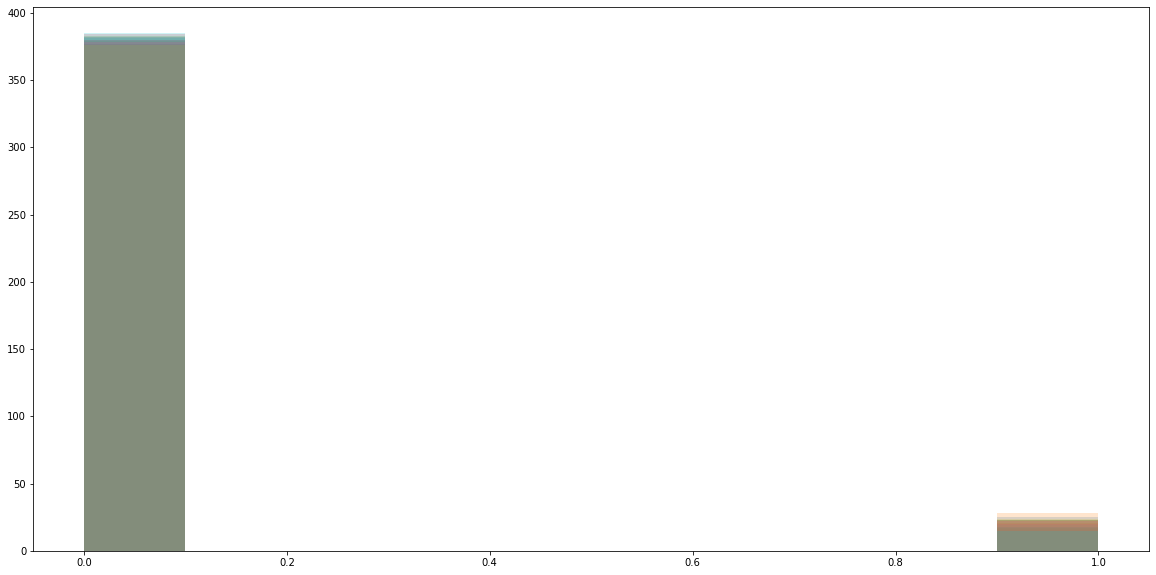

In [35]:
for key in mode_dict:
    plt.hist(mode_dict[key], alpha=0.2);
# for key in mean_dict:
#     plt.hist(mean_dict[key], alpha=0.2);
# for key in diff_dict:
#     plt.hist(diff_dict[key], alpha=0.2);

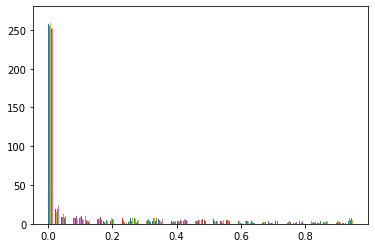

In [22]:
# most values are 0 (canny images are primarily black with a few white lines)
plt.hist(mean_dict.values(), bins=50);

In [29]:
# this code was necessary to round pre-scaled pixels to the nearest 0.0/1.0 value
round_dict = defaultdict(int)
for c in range(ncols):
    # Pull out all offset pairs for a given x
    gather = dup_vals[c]
    rounded = []
    for row in gather:
        rounded.append([0.0 if x <= 0.5 else 1.0 for x in row])
    round_dict[c] = np.array(rounded)

# this dictionary finds the mode (0/1) per row for a gather 
mode_dict = defaultdict(list)
for c in range(ncols):
    gather = round_dict[c]
    for row in gather:
        mode_val, _ = mode(row)
        mode_dict[c].append(mode_val[0])

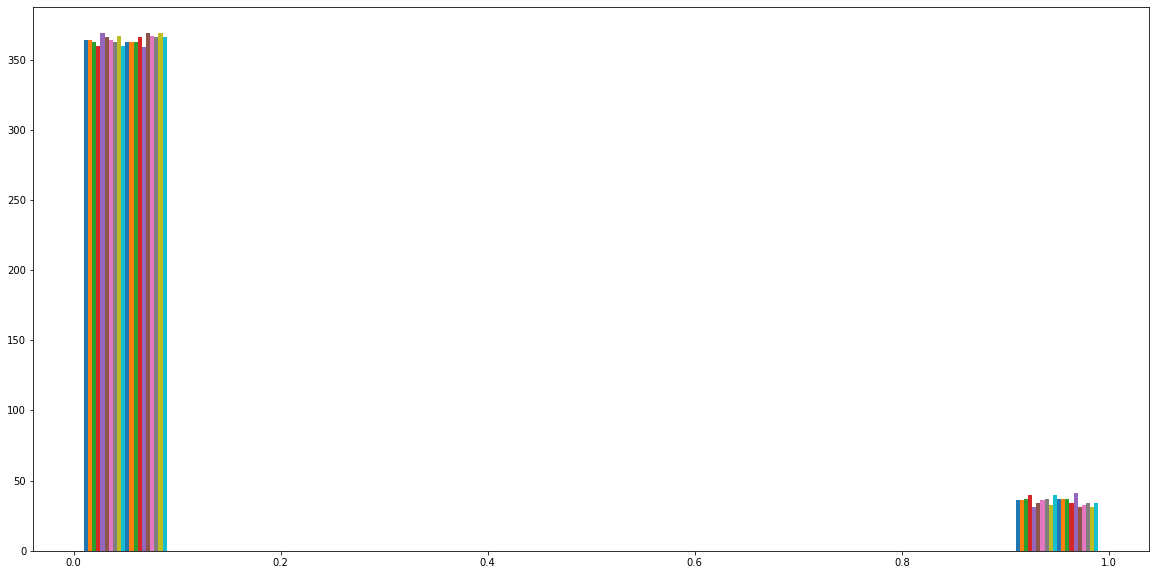

In [21]:
# this plots the histogram distribution of all 1058 gathers for a given file
values = mode_dict.values()
plt.figure(figsize=(20, 10))
plt.hist(values);

In [ ]:
# computes horizontal derivative (vertical edges)
sub_arr_x = ndimage.sobel(sub_arr, 0)
axarr[c].imshow(sub_arr_x, cmap = 'gray')

# computes vertical derivative (horizontal edges)
sub_arr_y = ndimage.sobel(sub_arr, 1)
axarr[c+1].imshow(sub_arr_y, cmap = 'gray')

# computes vertical derivative (horizontal edges)
sub_arr_lap = ndimage.laplace(sub_arr)
axarr[c+2].imshow(sub_arr_lap, cmap = 'gray') 